In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

#import aparent.visualization as vis

#from aparent_predictor import *


Using TensorFlow backend.


In [2]:
#Store variant prediction dataframe

variant_df = pd.read_csv('aparent_resnet_variant_predictions_polyadb_no_sequences_no_cutoff.csv', sep='\t')


In [2]:
#Load APADB Data and filter on targeted genes

#genes = ['RUNX1', 'CEBPA', 'GATA2', 'ANKRD26', 'DDX41', 'ETV6', 'PTEN', 'BRCA1', 'BRCA2', 'TP53', 'APC', 'ATM', 'PALB2', 'MSH2', 'MLH1', 'MSH6', 'PMS2', 'MUTYH']

polyadb_df = pd.read_csv('polyadb_processed.csv', sep=',')

#polyadb_df = polyadb_df.loc[polyadb_df['gene'].isin(genes)].reset_index(drop=True).copy()
polyadb_df = polyadb_df.loc[((~polyadb_df['gene'].isnull()) & (polyadb_df['gene'] != 'na')) & (polyadb_df['pas'] != -1)].reset_index(drop=True).copy()

print('len(polyadb_df) = ' + str(len(polyadb_df)))


len(polyadb_df) = 175451


In [3]:
#Process PolyaDB data

polyadb_df_minus = polyadb_df.query("strand == '-'").copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df.query("strand == '+'").copy().reset_index(drop=True)

polyadb_df_minus = polyadb_df_minus.sort_values(by='pas_pos', ascending=False).copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df_plus.sort_values(by='pas_pos', ascending=True).copy().reset_index(drop=True)

new_gene_id_list_plus = []
sitenum_list_plus = []
gene_id_dict = {}
for _, row in polyadb_df_plus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_plus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_plus.append(gene_id_dict[gene])

polyadb_df_plus['gene_id'] = new_gene_id_list_plus
polyadb_df_plus['sitenum'] = sitenum_list_plus

new_gene_id_list_minus = []
sitenum_list_minus = []
gene_id_dict = {}
for _, row in polyadb_df_minus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_minus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_minus.append(gene_id_dict[gene])

polyadb_df_minus['gene_id'] = new_gene_id_list_minus
polyadb_df_minus['sitenum'] = sitenum_list_minus

polyadb_df = pd.concat([polyadb_df_plus, polyadb_df_minus])

polyadb_df = polyadb_df.sort_values(by=['gene', 'sitenum'], ascending=True).reset_index(drop=True).copy()

In [5]:
#Get variant positions in hg38 coordinates

polyadb_bed_hg19 = pd.read_csv("polyadb_coordinates_hg19.bed", sep='\t', header=None, names=['chrom', 'pas_pos_hg19', 'end', 'gene', 'gene_id', 'strand'])
polyadb_bed_hg38 = pd.read_csv("polyadb_coordinates_hg38.bed", sep='\t', header=None, names=['chrom', 'pas_pos_hg38', 'end', 'gene', 'gene_id', 'strand'])

polyadb_bed_hg38 = polyadb_bed_hg38.join(polyadb_bed_hg19[['gene_id', 'pas_pos_hg19']].set_index('gene_id'), on='gene_id', how='inner').copy().reset_index(drop=True)

polyadb_bed_hg38['padb_join_id'] = polyadb_bed_hg38['chrom'] + "_" + polyadb_bed_hg38['pas_pos_hg19'].astype(str) + "_" + polyadb_bed_hg38['gene']
polyadb_df['padb_join_id'] = polyadb_df['chrom'] + "_" + polyadb_df['pas_pos'].astype(str) + "_" + polyadb_df['gene']

polyadb_df = polyadb_df.join(polyadb_bed_hg38[['padb_join_id', 'pas_pos_hg38']].set_index("padb_join_id"), on='padb_join_id', how='inner').copy().reset_index(drop=True)

#polyadb_df = polyadb_df.query("site_type == '3_most_exon'")

polyadb_df = polyadb_df.drop_duplicates(subset=['gene_id'], keep='first').copy().reset_index(drop=True)

variant_df = variant_df.join(polyadb_df[['gene_id', 'pas_pos', 'pas_pos_hg38']].set_index("gene_id"), on='gene_id', how='inner').copy().reset_index(drop=True)

variant_df['var_position_hg38'] = variant_df['var_position'] - variant_df['pas_pos'] + variant_df['pas_pos_hg38']


In [4]:
#Get CausalDB credible sets

causaldb_meta_df = pd.read_csv("causaldb_credible_set/causaldb_meta_info_v1.txt", sep='\t')

causaldb_dfs = []
for _, row in causaldb_meta_df.iterrows() :
    causaldb_dfs.append(
        pd.read_csv("causaldb_credible_set/" + row["ID"] + "_total_credible_set.txt", sep='\t')
    )

causaldb_df = pd.concat(causaldb_dfs).copy().reset_index(drop=True)

print("len(causaldb_df) = " + str(len(causaldb_df)))


'\ncausaldb_dfs = []\nfor _, row in causaldb_meta_df.iterrows() :\n    causaldb_dfs.append(\n        pd.read_csv("causaldb_credible_set/" + row["ID"] + "_total_credible_set.txt", sep=\'\t\')\n    )\n\ncausaldb_df = pd.concat(causaldb_dfs).copy().reset_index(drop=True)\n\nprint("len(causaldb_df) = " + str(len(causaldb_df)))\n'

In [7]:
#Get CausalDB significant non-causal variants

non_causaldb_df = pd.read_csv("causaldb_credible_set/causaldb_sig_noncausal_v1.txt", sep='\t')

print("len(non_causaldb_df) = " + str(len(non_causaldb_df)))


len(non_causaldb_df) = 705151


In [8]:
#Map variants to predictions

causaldb_df['causaldb_join_id'] = "chr" + causaldb_df['CHR'].astype(str) + "_" + causaldb_df['BP'].astype(str)
variant_df['causaldb_join_id'] = variant_df['chrom'] + "_" + variant_df['var_position'].astype(str)

#causaldb_df = causaldb_df.drop_duplicates(subset=['causaldb_join_id'], keep='first').copy().reset_index(drop=True)

variant_df_gwas = variant_df.join(causaldb_df[["causaldb_join_id", 'rsID', 'MAF', 'EA', 'NEA', 'BETA', 'SE', 'P', 'Zscore', 'PAINTOR', 'CAVIARBF', 'FINEMAP', 'meta_id']].set_index("causaldb_join_id"), on='causaldb_join_id', how='inner').copy().reset_index(drop=True)
variant_df_gwas = variant_df_gwas.query("EA == var_nucleotide").copy().reset_index(drop=True)

#variant_df_gwas.to_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_causaldb_no_cutoff.csv", sep='\t', index=False)

#Map non-causal variants to predictions

non_causaldb_df['causaldb_join_id'] = "chr" + non_causaldb_df['CHR'].astype(str) + "_" + non_causaldb_df['BP'].astype(str)
variant_df['causaldb_join_id'] = variant_df['chrom'] + "_" + variant_df['var_position'].astype(str)

#non_causaldb_df = non_causaldb_df.drop_duplicates(subset=['causaldb_join_id'], keep='first').copy().reset_index(drop=True)

variant_df_gwas_noncausal = variant_df.join(non_causaldb_df[["causaldb_join_id", 'rsID', 'MAF', 'EA', 'NEA', 'BETA', 'SE', 'P', 'Zscore', 'PAINTOR', 'CAVIARBF', 'FINEMAP', 'meta_id']].set_index("causaldb_join_id"), on='causaldb_join_id', how='inner').copy().reset_index(drop=True)
variant_df_gwas_noncausal = variant_df_gwas_noncausal.query("EA == var_nucleotide").copy().reset_index(drop=True)

#variant_df_gwas_noncausal.to_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_noncausaldb_no_cutoff.csv", sep='\t', index=False)


In [5]:

variant_df_gwas = pd.read_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_causaldb_no_cutoff.csv", sep='\t')
variant_df_gwas_noncausal = pd.read_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_noncausaldb_no_cutoff.csv", sep='\t')


In [6]:
#Drop duplicates for partially overlapping annotated PASs

variant_df_gwas['rsID'] = "rs" + variant_df_gwas['rsID'].astype(int).astype(str)

variant_df_gwas['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas['delta_logodds_77_127'])

variant_df_gwas['rel_var_position'] = -1
variant_df_gwas.loc[variant_df_gwas['strand'] == '+', 'rel_var_position'] = variant_df_gwas['var_position'] - (variant_df_gwas['pas_pos'] - 70 + 1)
variant_df_gwas.loc[variant_df_gwas['strand'] == '-', 'rel_var_position'] = ((variant_df_gwas['pas_pos'] - (205 - 70)) + 205) - variant_df_gwas['var_position']

variant_df_gwas['target_rel_var_position'] = np.abs(90 - variant_df_gwas['rel_var_position'])
variant_df_gwas['delta_logodds_77_127_abs'] = -variant_df_gwas['delta_logodds_77_127_abs']
variant_df_gwas = variant_df_gwas.sort_values(by=['target_rel_var_position', 'delta_logodds_77_127_abs'], ascending=True).drop_duplicates(subset=['causaldb_join_id', 'meta_id'], keep='first').copy().reset_index(drop=True)

#Drop duplicates for partially overlapping annotated PASs (non-causal)

variant_df_gwas_noncausal['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas_noncausal['delta_logodds_77_127'])

variant_df_gwas_noncausal['rel_var_position'] = -1
variant_df_gwas_noncausal.loc[variant_df_gwas_noncausal['strand'] == '+', 'rel_var_position'] = variant_df_gwas_noncausal['var_position'] - (variant_df_gwas_noncausal['pas_pos'] - 70 + 1)
variant_df_gwas_noncausal.loc[variant_df_gwas_noncausal['strand'] == '-', 'rel_var_position'] = ((variant_df_gwas_noncausal['pas_pos'] - (205 - 70)) + 205) - variant_df_gwas_noncausal['var_position']

variant_df_gwas_noncausal['target_rel_var_position'] = np.abs(90 - variant_df_gwas_noncausal['rel_var_position'])
variant_df_gwas_noncausal['delta_logodds_77_127_abs'] = -variant_df_gwas_noncausal['delta_logodds_77_127_abs']
variant_df_gwas_noncausal = variant_df_gwas_noncausal.sort_values(by=['target_rel_var_position', 'delta_logodds_77_127_abs'], ascending=True).drop_duplicates(subset=['causaldb_join_id', 'meta_id'], keep='first').copy().reset_index(drop=True)


In [7]:
#Aggregate summary statistic for unique SNPs (by rsID)

variant_df_gwas_lead = variant_df_gwas.copy().sort_values(by='FINEMAP', ascending=False).drop_duplicates("causaldb_join_id").copy().reset_index(drop=True)

print("len(variant_df_gwas_lead) = " + str(len(variant_df_gwas_lead)))


len(variant_df_gwas_lead) = 8072


n = 8072
n (>= 1.4-fold) = 999

n = 152 (PP >= 0.9)
n (>= 1.4-fold) = 26 (PP >= 0.9)


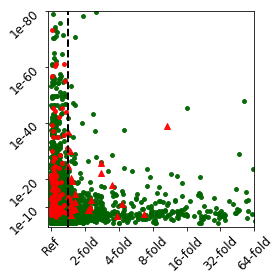

In [36]:

f = plt.figure(figsize=(4, 4))

variant_df_gwas_lead['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas_lead['delta_logodds_77_127'])

variant_df_gwas_lead_non_signi = variant_df_gwas_lead.query("FINEMAP < 0.9")
variant_df_gwas_lead_signi = variant_df_gwas_lead.query("FINEMAP >= 0.9")

print("n = " + str(len(variant_df_gwas_lead)))
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead.query("delta_logodds_77_127_abs >= 0.336"))))

print("")
print("n = " + str(len(variant_df_gwas_lead_signi)) + " (PP >= 0.9)")
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336"))) + " (PP >= 0.9)")

plt.scatter(variant_df_gwas_lead_non_signi['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_non_signi['P'], 1e-200, 1.)) / np.log(10), color='darkgreen', s=15, alpha=0.95)

plt.scatter(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs < 0.336")['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs < 0.336")['P'], 1e-200, 1.)) / np.log(10), color='red', s=15, alpha=0.95)
plt.scatter(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336")['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336")['P'], 1e-200, 1.)) / np.log(10), color='red', s=35, marker="^", alpha=0.95)

plt.axvline(x=np.log2(1.4), linestyle='--', linewidth=2, color='black')

plt.xlim(-0.1, 6.0)
plt.ylim(3, 80)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Ref', '2-fold', '4-fold', '8-fold', '16-fold', '32-fold', '64-fold'], fontsize=12, rotation=45)
plt.yticks([10, 20, 40, 60, 80], ["1e-10", "1e-20", "1e-40", "1e-60", "1e-80", "1e-100"], fontsize=12, rotation=45)

plt.savefig("causaldb_aparent_resnet_scatter_pp_09_v2.png", transparent=True, dpi=300)
plt.savefig("causaldb_aparent_resnet_scatter_pp_09_v2.eps")

plt.tight_layout()

plt.show()


n = 8072
n (>= 1.4-fold) = 999

n = 121 (PP >= 0.5)
n (>= 1.4-fold) = 13 (PP >= 0.5)

n = 152 (PP >= 0.9)
n (>= 1.4-fold) = 26 (PP >= 0.9)


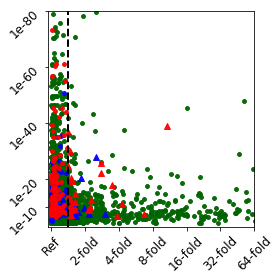

In [38]:

f = plt.figure(figsize=(4, 4))

variant_df_gwas_lead['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas_lead['delta_logodds_77_127'])

variant_df_gwas_lead_non_signi = variant_df_gwas_lead.query("FINEMAP < 0.5")
variant_df_gwas_lead_semi_signi = variant_df_gwas_lead.query("FINEMAP >= 0.5 and FINEMAP < 0.9")
variant_df_gwas_lead_signi = variant_df_gwas_lead.query("FINEMAP >= 0.9")

print("n = " + str(len(variant_df_gwas_lead)))
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead.query("delta_logodds_77_127_abs >= 0.336"))))

print("")
print("n = " + str(len(variant_df_gwas_lead_semi_signi)) + " (PP >= 0.5)")
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead_semi_signi.query("delta_logodds_77_127_abs >= 0.336"))) + " (PP >= 0.5)")

print("")
print("n = " + str(len(variant_df_gwas_lead_signi)) + " (PP >= 0.9)")
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336"))) + " (PP >= 0.9)")

plt.scatter(variant_df_gwas_lead_non_signi['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_non_signi['P'], 1e-200, 1.)) / np.log(10), color='darkgreen', s=15, alpha=0.95)

plt.scatter(variant_df_gwas_lead_semi_signi.query("delta_logodds_77_127_abs < 0.336")['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_semi_signi.query("delta_logodds_77_127_abs < 0.336")['P'], 1e-200, 1.)) / np.log(10), color='blue', s=15, alpha=0.95)
plt.scatter(variant_df_gwas_lead_semi_signi.query("delta_logodds_77_127_abs >= 0.336")['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_semi_signi.query("delta_logodds_77_127_abs >= 0.336")['P'], 1e-200, 1.)) / np.log(10), color='blue', s=35, marker="^", alpha=0.95)

plt.scatter(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs < 0.336")['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs < 0.336")['P'], 1e-200, 1.)) / np.log(10), color='red', s=15, alpha=0.95)
plt.scatter(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336")['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336")['P'], 1e-200, 1.)) / np.log(10), color='red', s=35, marker="^", alpha=0.95)

plt.axvline(x=np.log2(1.4), linestyle='--', linewidth=2, color='black')

plt.xlim(-0.1, 6.0)
plt.ylim(3, 80)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Ref', '2-fold', '4-fold', '8-fold', '16-fold', '32-fold', '64-fold'], fontsize=12, rotation=45)
plt.yticks([10, 20, 40, 60, 80], ["1e-10", "1e-20", "1e-40", "1e-60", "1e-80", "1e-100"], fontsize=12, rotation=45)

plt.savefig("causaldb_aparent_resnet_scatter_pp_05_09_v2.png", transparent=True, dpi=300)
plt.savefig("causaldb_aparent_resnet_scatter_pp_05_09_v2.eps")

plt.tight_layout()

plt.show()


In [8]:
#Filter on 3' UTR SNPs only

variant_df_gwas = variant_df_gwas.query("site_type == '3_most_exon'").copy().reset_index(drop=True)
variant_df_gwas_lead = variant_df_gwas_lead.query("site_type == '3_most_exon'").copy().reset_index(drop=True)
variant_df_gwas_noncausal = variant_df_gwas_noncausal.query("site_type == '3_most_exon'").copy().reset_index(drop=True)


n = 4200
n (>= 1.4-fold) = 554

n = 70 (PP >= 0.5)
n (>= 1.4-fold) = 8 (PP >= 0.5)

n = 96 (PP >= 0.9)
n (>= 1.4-fold) = 17 (PP >= 0.9)


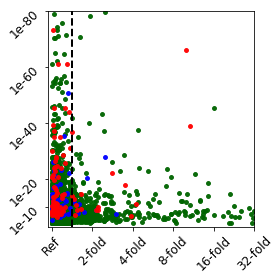

In [9]:

f = plt.figure(figsize=(4, 4))

variant_df_gwas_lead['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas_lead['delta_logodds_77_127'])

variant_df_gwas_lead_non_signi = variant_df_gwas_lead.query("FINEMAP < 0.5")
variant_df_gwas_lead_semi_signi = variant_df_gwas_lead.query("FINEMAP >= 0.5 and FINEMAP < 0.9")
variant_df_gwas_lead_signi = variant_df_gwas_lead.query("FINEMAP >= 0.9")

print("n = " + str(len(variant_df_gwas_lead)))
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead.query("delta_logodds_77_127_abs >= 0.336"))))

print("")
print("n = " + str(len(variant_df_gwas_lead_semi_signi)) + " (PP >= 0.5)")
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead_semi_signi.query("delta_logodds_77_127_abs >= 0.336"))) + " (PP >= 0.5)")

print("")
print("n = " + str(len(variant_df_gwas_lead_signi)) + " (PP >= 0.9)")
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336"))) + " (PP >= 0.9)")

plt.scatter(variant_df_gwas_lead_non_signi['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_non_signi['P'], 1e-200, 1.)) / np.log(10), color='darkgreen', s=15, alpha=0.95)

plt.scatter(variant_df_gwas_lead_semi_signi['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_semi_signi['P'], 1e-200, 1.)) / np.log(10), color='blue', s=15, alpha=0.95)

plt.scatter(variant_df_gwas_lead_signi['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_signi['P'], 1e-200, 1.)) / np.log(10), color='red', s=15, alpha=0.95)

#Re-plot rs6796 with other association to make it visible
rs6796_df = variant_df_gwas.query("rsID == 'rs6796' and meta_id == 'AT690'").copy()
rs6796_df['delta_logodds_77_127_abs'] = np.abs(rs6796_df['delta_logodds_77_127'])
plt.scatter(rs6796_df['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(rs6796_df['P'], 1e-200, 1.)) / np.log(10), color='red', s=15, alpha=0.95)

plt.axvline(x=np.log2(1.4), linestyle='--', linewidth=2, color='black')

plt.xlim(-0.1, 5.0)
plt.ylim(3, 80)

plt.xticks([0, 1, 2, 3, 4, 5], ['Ref', '2-fold', '4-fold', '8-fold', '16-fold', '32-fold'], fontsize=12, rotation=45)
plt.yticks([10, 20, 40, 60, 80], ["1e-10", "1e-20", "1e-40", "1e-60", "1e-80", "1e-100"], fontsize=12, rotation=45)

plt.savefig("causaldb_aparent_resnet_scatter_utr3_only_pp_05_09_v2.png", transparent=True, dpi=300)
plt.savefig("causaldb_aparent_resnet_scatter_utr3_only_pp_05_09_v2.eps")

plt.tight_layout()

plt.show()


n = 4200
n (>= 1.4-fold) = 554

n = 70 (PP >= 0.5)
n (>= 1.4-fold) = 8 (PP >= 0.5)

n = 96 (PP >= 0.9)
n (>= 1.4-fold) = 17 (PP >= 0.9)


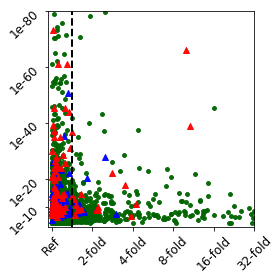

In [10]:

f = plt.figure(figsize=(4, 4))

variant_df_gwas_lead['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas_lead['delta_logodds_77_127'])

variant_df_gwas_lead_non_signi = variant_df_gwas_lead.query("FINEMAP < 0.5")
variant_df_gwas_lead_semi_signi = variant_df_gwas_lead.query("FINEMAP >= 0.5 and FINEMAP < 0.9")
variant_df_gwas_lead_signi = variant_df_gwas_lead.query("FINEMAP >= 0.9")

print("n = " + str(len(variant_df_gwas_lead)))
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead.query("delta_logodds_77_127_abs >= 0.336"))))

print("")
print("n = " + str(len(variant_df_gwas_lead_semi_signi)) + " (PP >= 0.5)")
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead_semi_signi.query("delta_logodds_77_127_abs >= 0.336"))) + " (PP >= 0.5)")

print("")
print("n = " + str(len(variant_df_gwas_lead_signi)) + " (PP >= 0.9)")
print("n (>= 1.4-fold) = " + str(len(variant_df_gwas_lead_signi.query("delta_logodds_77_127_abs >= 0.336"))) + " (PP >= 0.9)")

plt.scatter(variant_df_gwas_lead_non_signi['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_non_signi['P'], 1e-200, 1.)) / np.log(10), color='darkgreen', s=15, alpha=0.95)

plt.scatter(variant_df_gwas_lead_semi_signi['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_semi_signi['P'], 1e-200, 1.)) / np.log(10), color='blue', s=35, marker="^", alpha=0.95)

plt.scatter(variant_df_gwas_lead_signi['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(variant_df_gwas_lead_signi['P'], 1e-200, 1.)) / np.log(10), color='red', s=35, marker="^", alpha=0.95)

#Re-plot rs6796 with other association to make it visible
rs6796_df = variant_df_gwas.query("rsID == 'rs6796' and meta_id == 'AT690'").copy()
rs6796_df['delta_logodds_77_127_abs'] = np.abs(rs6796_df['delta_logodds_77_127'])
plt.scatter(rs6796_df['delta_logodds_77_127_abs'] / np.log(2.), -np.log(np.clip(rs6796_df['P'], 1e-200, 1.)) / np.log(10), color='red', s=35, marker="^", alpha=0.95)

plt.axvline(x=np.log2(1.4), linestyle='--', linewidth=2, color='black')

plt.xlim(-0.1, 5.0)
plt.ylim(3, 80)

plt.xticks([0, 1, 2, 3, 4, 5], ['Ref', '2-fold', '4-fold', '8-fold', '16-fold', '32-fold'], fontsize=12, rotation=45)
plt.yticks([10, 20, 40, 60, 80], ["1e-10", "1e-20", "1e-40", "1e-60", "1e-80", "1e-100"], fontsize=12, rotation=45)

plt.savefig("causaldb_aparent_resnet_scatter_utr3_only_pp_05_09_v2_alt.png", transparent=True, dpi=300)
plt.savefig("causaldb_aparent_resnet_scatter_utr3_only_pp_05_09_v2_alt.eps")

plt.tight_layout()

plt.show()


In [44]:
#Get SNPs with PP >= 0.5 and PP >= 0.9

variant_df_gwas_semi_signi = variant_df_gwas.query("FINEMAP >= 0.5 and FINEMAP < 0.9").copy()
variant_df_gwas_lead_semi_signi = variant_df_gwas_lead_semi_signi.query("FINEMAP >= 0.5 and FINEMAP < 0.9").copy()

variant_df_gwas_semi_signi = variant_df_gwas_semi_signi.join(causaldb_meta_df[['ID', 'Trait', 'MeSH_term']].set_index("ID"), on='meta_id', how='inner').copy().reset_index(drop=True)
variant_df_gwas_lead_semi_signi = variant_df_gwas_lead_semi_signi.join(causaldb_meta_df[['ID', 'Trait', 'MeSH_term']].set_index("ID"), on='meta_id', how='inner').copy().reset_index(drop=True)

variant_df_gwas_signi = variant_df_gwas.query("FINEMAP >= 0.9").copy()
variant_df_gwas_lead_signi = variant_df_gwas_lead_signi.query("FINEMAP >= 0.9").copy()

variant_df_gwas_signi = variant_df_gwas_signi.join(causaldb_meta_df[['ID', 'Trait', 'MeSH_term']].set_index("ID"), on='meta_id', how='inner').copy().reset_index(drop=True)
variant_df_gwas_lead_signi = variant_df_gwas_lead_signi.join(causaldb_meta_df[['ID', 'Trait', 'MeSH_term']].set_index("ID"), on='meta_id', how='inner').copy().reset_index(drop=True)

variant_df_gwas_lead_semi_signi['delta_logodds_77_127_abs_log_2'] = 2**(variant_df_gwas_lead_semi_signi['delta_logodds_77_127_abs'] / np.log(2.))
variant_df_gwas_lead_signi['delta_logodds_77_127_abs_log_2'] = 2**(variant_df_gwas_lead_signi['delta_logodds_77_127_abs'] / np.log(2.))


In [45]:
#Get variant ids

rs_ids = set(variant_df_gwas['rsID'].unique().tolist())

rs_ids_semi_signi = set(variant_df_gwas_semi_signi['rsID'].unique().tolist())
rs_ids_lead_semi_signi = set(variant_df_gwas_lead_semi_signi['rsID'].unique().tolist())

rs_ids_signi = set(variant_df_gwas_signi['rsID'].unique().tolist())
rs_ids_lead_signi = set(variant_df_gwas_lead_signi['rsID'].unique().tolist())


In [46]:
#Top candidates from CasualDB with PP >= 0.9 (cutoff immediately after known pathogenic variant rs1799963)

cand_rs_ids = variant_df_gwas_lead_signi.sort_values(by='delta_logodds_77_127_abs_log_2', ascending=False).query("delta_logodds_77_127_abs_log_2 >= 1.4")['rsID'].values.tolist()

print("--- SNPs from credible set w. PP >= 0.9 ---")

for cand_rs_id in cand_rs_ids :
    print((cand_rs_id + " " * 15)[:15] + ": " + str((cand_rs_id in rs_ids_signi)))
    
    if cand_rs_id in rs_ids_signi :
        print(" - delta_logodds_77_127 = " + str(round(variant_df_gwas_lead_signi.query("rsID == '" + cand_rs_id + "'").iloc[0]['delta_logodds_77_127'], 4)))
        print(" - delta_logodds_77_127_abs_log_2 = " + str(round(2**(np.abs(variant_df_gwas_lead_signi.query("rsID == '" + cand_rs_id + "'").iloc[0]['delta_logodds_77_127']) / np.log(2.)), 4)))
        
        subset_df = variant_df_gwas_signi.query("rsID == '" + cand_rs_id + "'")
        for _, row in subset_df.iterrows() :
            print(" -- " + row['Trait'] + ", p-value = " + str(row['P']) + ", FINEMAP = " + str(row['FINEMAP']))

        print("")


--- SNPs from credible set w. PP >= 0.9 ---
rs78378222     : True
 - delta_logodds_77_127 = -2.3624
 - delta_logodds_77_127_abs_log_2 = 10.6162
 -- Mean corpuscular hemoglobin, p-value = 6.44e-09, FINEMAP = 0.997827
 -- Red blood cell (erythrocyte) count, p-value = 7.6177e-25, FINEMAP = 0.921756
 -- Mean corpuscular haemoglobin, p-value = 1.1518e-23, FINEMAP = 1.0
 -- Mean corpuscular volume, p-value = 1.8429000000000003e-23, FINEMAP = 1.0
 -- Impedance measures - Basal metabolic rate, p-value = 1.538e-34, FINEMAP = 1.0
 -- Impedance measures - Whole body water mass, p-value = 1.2809999999999999e-40, FINEMAP = 1.0
 -- Weight, p-value = 1.7840000000000003e-18, FINEMAP = 0.999278
 -- Impedance measures - Weight, p-value = 4.428e-18, FINEMAP = 0.999086
 -- Impedance measures - Leg fat-free mass (right), p-value = 7.078e-33, FINEMAP = 1.0
 -- Impedance measures - Leg predicted mass (right), p-value = 6.511e-33, FINEMAP = 1.0
 -- Impedance measures - Leg fat-free mass (left), p-value = 1.22

 -- Frequency of travelling from home to job workplace, p-value = 4.319e-10, FINEMAP = 0.999907

rs148354990    : True
 - delta_logodds_77_127 = 0.4284
 - delta_logodds_77_127_abs_log_2 = 1.5349
 -- Ease of skin tanning, p-value = 6.536e-10, FINEMAP = 0.974185

rs7078         : True
 - delta_logodds_77_127 = -0.4102
 - delta_logodds_77_127_abs_log_2 = 1.5071
 -- Heel bone mineral density (BMD) T-score, automated, p-value = 2.08993e-11, FINEMAP = 0.998068

rs3741434      : True
 - delta_logodds_77_127 = -0.4016
 - delta_logodds_77_127_abs_log_2 = 1.4942
 -- Cognitive performance, p-value = 4.68e-08, FINEMAP = 0.96687

rs8045438      : True
 - delta_logodds_77_127 = 0.3838
 - delta_logodds_77_127_abs_log_2 = 1.4679
 -- Dihomo-gamma-linolenic acid, p-value = 7.89e-14, FINEMAP = 1.0

rs190092330    : True
 - delta_logodds_77_127 = 0.3455
 - delta_logodds_77_127_abs_log_2 = 1.4127
 -- Nucleated red blood cell count, p-value = 1.0699e-14, FINEMAP = 0.947007

rs1799963      : True
 - delta_lo

In [47]:
#Top candidates from CasualDB with PP >= 0.5 (cutoff immediately after known pathogenic variant rs1799963)

cand_rs_ids = variant_df_gwas_lead_semi_signi.sort_values(by='delta_logodds_77_127_abs_log_2', ascending=False).query("delta_logodds_77_127_abs_log_2 >= 1.4")['rsID'].values.tolist()

print("--- SNPs from credible set w. PP >= 0.5 ---")

for cand_rs_id in cand_rs_ids :
    print((cand_rs_id + " " * 15)[:15] + ": " + str((cand_rs_id in rs_ids_semi_signi)))
    
    if cand_rs_id in rs_ids_semi_signi :
        print(" - delta_logodds_77_127 = " + str(round(variant_df_gwas_lead_semi_signi.query("rsID == '" + cand_rs_id + "'").iloc[0]['delta_logodds_77_127'], 4)))
        print(" - delta_logodds_77_127_abs_log_2 = " + str(round(2**(np.abs(variant_df_gwas_lead_semi_signi.query("rsID == '" + cand_rs_id + "'").iloc[0]['delta_logodds_77_127']) / np.log(2.)), 4)))
        
        subset_df = variant_df_gwas_semi_signi.query("rsID == '" + cand_rs_id + "'")
        for _, row in subset_df.iterrows() :
            print(" -- " + row['Trait'] + ", p-value = " + str(row['P']) + ", FINEMAP = " + str(row['FINEMAP']))

        print("")


--- SNPs from credible set w. PP >= 0.5 ---
rs11556473     : True
 - delta_logodds_77_127 = -1.1012
 - delta_logodds_77_127_abs_log_2 = 3.0076
 -- Salt added to food, p-value = 3.142e-08, FINEMAP = 0.523251

rs2732480      : True
 - delta_logodds_77_127 = 0.9093
 - delta_logodds_77_127_abs_log_2 = 2.4826
 -- Red blood cell count, p-value = 1.44e-17, FINEMAP = 0.529911
 -- Hematocrit, p-value = 3.9599999999999996e-36, FINEMAP = 0.585425
 -- Hemoglobin concentration, p-value = 7.65e-29, FINEMAP = 0.602596

rs12142199     : True
 - delta_logodds_77_127 = 0.7497
 - delta_logodds_77_127_abs_log_2 = 2.1164
 -- Ulcerative colitis, p-value = 6.72223986453e-10, FINEMAP = 0.5131319999999999

rs1049868      : True
 - delta_logodds_77_127 = -0.6088
 - delta_logodds_77_127_abs_log_2 = 1.8382
 -- Mean platelet volume, p-value = 4.7499999999999995e-09, FINEMAP = 0.531417
 -- Mean platelet (thrombocyte) volume, p-value = 4.977600000000001e-21, FINEMAP = 0.74954

rs703862       : True
 - delta_logodds_

In [48]:
#Candidates from GWAS catalog

cand_rs_ids = ['rs6796', 'rs35630683', 'rs78378222', 'rs2066865', 'rs16833132', 'rs8753', 'rs35979828', 'rs2732480', 'rs12459634', 'rs555328608', 'rs16833132']

print("--- SNPs from credible set w. PP > 0.9 ---")

for cand_rs_id in cand_rs_ids :
    print((cand_rs_id + " " * 15)[:15] + ": " + str((cand_rs_id in rs_ids_signi)))
    
    if cand_rs_id in rs_ids_signi :
        print(" - delta_logodds_77_127 = " + str(round(variant_df_gwas_lead_signi.query("rsID == '" + cand_rs_id + "'").iloc[0]['delta_logodds_77_127'], 4)))
        print(" - delta_logodds_77_127_abs_log_2 = " + str(round(2**(np.abs(variant_df_gwas_lead_signi.query("rsID == '" + cand_rs_id + "'").iloc[0]['delta_logodds_77_127']) / np.log(2.)), 4)))
        
        subset_df = variant_df_gwas_signi.query("rsID == '" + cand_rs_id + "'")
        for _, row in subset_df.iterrows() :
            print(" -- " + row['Trait'] + ", p-value = " + str(row['P']) + ", FINEMAP = " + str(row['FINEMAP']))

        print("")

print("")

print("--- SNPs from credible set ---")

for cand_rs_id in cand_rs_ids :
    print((cand_rs_id + " " * 15)[:15] + ": " + str((cand_rs_id in rs_ids)))


--- SNPs from credible set w. PP > 0.9 ---
rs6796         : True
 - delta_logodds_77_127 = -2.2975
 - delta_logodds_77_127_abs_log_2 = 9.9491
 -- Mean platelet (thrombocyte) volume, p-value = 8.899099999999991e-69, FINEMAP = 0.933805
 -- Monocyte count, p-value = 8.468099999999995e-67, FINEMAP = 0.999974
 -- Monocyte percentage, p-value = 1.2099999999999982e-87, FINEMAP = 0.99999
 -- Neutrophill percentage, p-value = 1.7466999999999994e-60, FINEMAP = 0.996227

rs35630683     : False
rs78378222     : True
 - delta_logodds_77_127 = -2.3624
 - delta_logodds_77_127_abs_log_2 = 10.6162
 -- Mean corpuscular hemoglobin, p-value = 6.44e-09, FINEMAP = 0.997827
 -- Red blood cell (erythrocyte) count, p-value = 7.6177e-25, FINEMAP = 0.921756
 -- Mean corpuscular haemoglobin, p-value = 1.1518e-23, FINEMAP = 1.0
 -- Mean corpuscular volume, p-value = 1.8429000000000003e-23, FINEMAP = 1.0
 -- Impedance measures - Basal metabolic rate, p-value = 1.538e-34, FINEMAP = 1.0
 -- Impedance measures - Whole